<a href="https://colab.research.google.com/github/Mu-niu13/AIPI-590-HWs/blob/main/Explainable%20Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Explainable Deep Learning

### Mu Niu


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mu-niu13/AIPI-590-HWs/blob/main/Explainable%20Deep%20Learning.ipynb)

Claude Sonnet 4.5 is used to help with coding, while interpretation on the results are my own words

#### Load Libs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [ ]:
# california housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target, name='MedHouseVal')

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


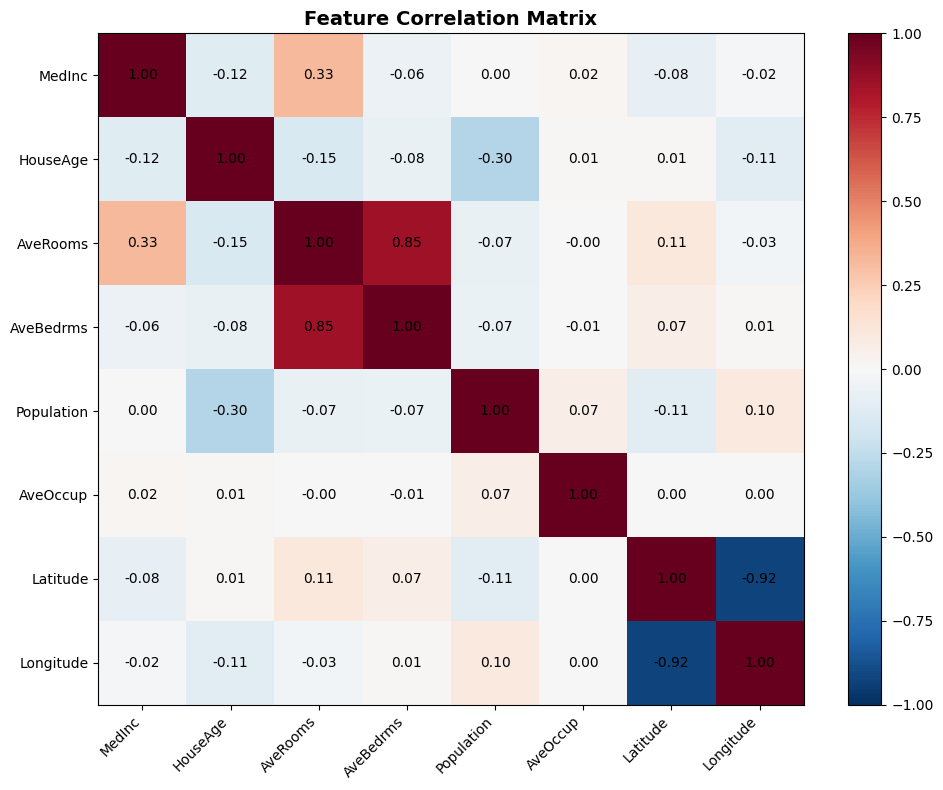

In [ ]:
correlation_matrix = X.corr()

# heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# add correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im)
plt.tight_layout()
plt.show()

From the heat map above, we can see that the correlated pairs are:
* MedInc & AveRooms: 0.327
* AveRooms & AveBedrms: 0.848
* Latitude & Longitude: -0.925

#### Random Forest Model

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=590)

rf_model = RandomForestRegressor(n_estimators=100, random_state=590, n_jobs=-1)
rf_model.fit(X_train, y_train)

# performance
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R2: {r2:.3f}")

# feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

MSE: 0.266
R2: 0.805
MedInc: 0.521
AveOccup: 0.138
Latitude: 0.089
Longitude: 0.088
HouseAge: 0.056
AveRooms: 0.046
Population: 0.033
AveBedrms: 0.029



Analyzing features: ['MedInc', 'AveOccup', 'HouseAge', 'Latitude']


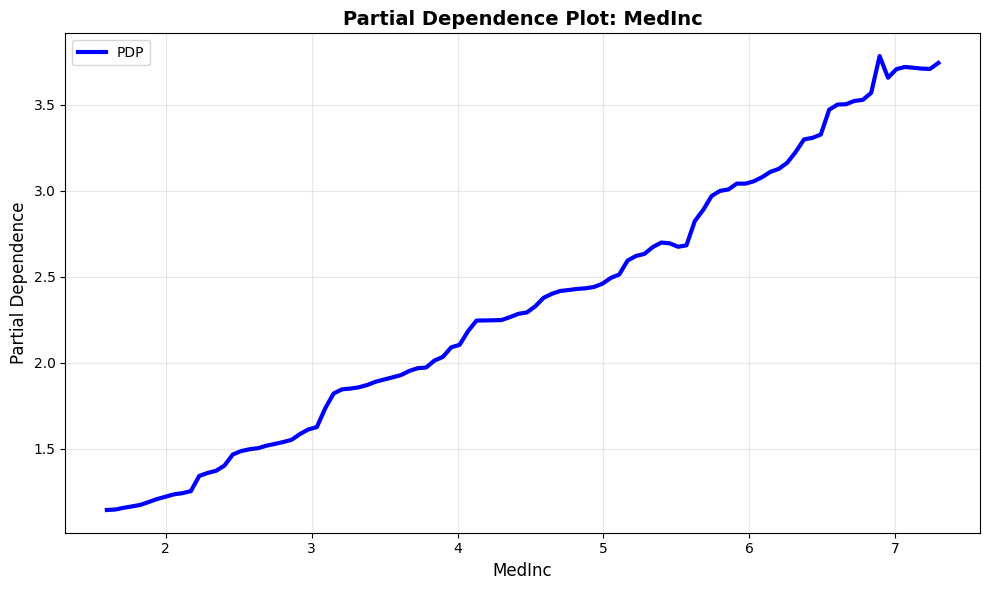

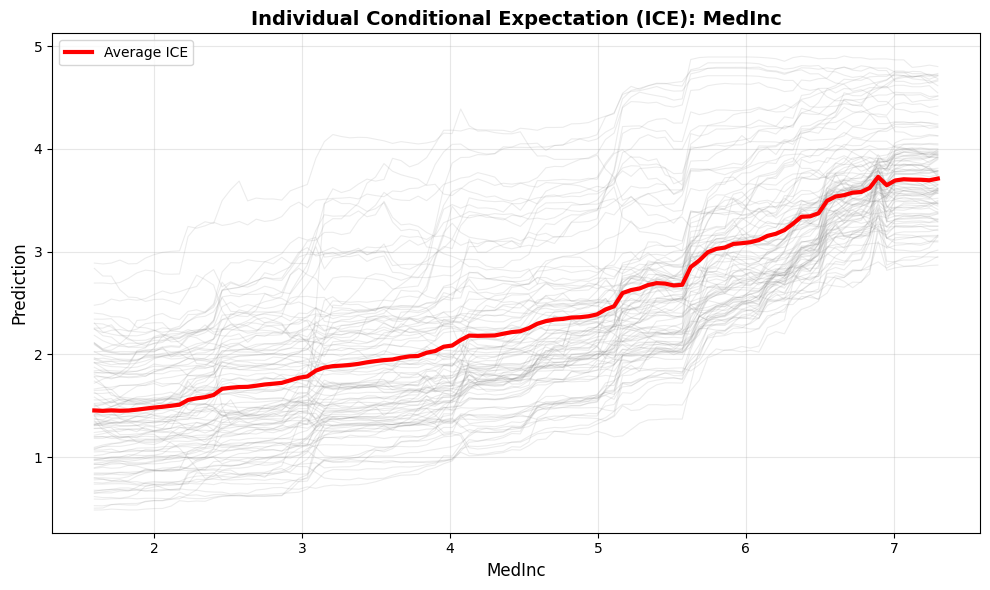

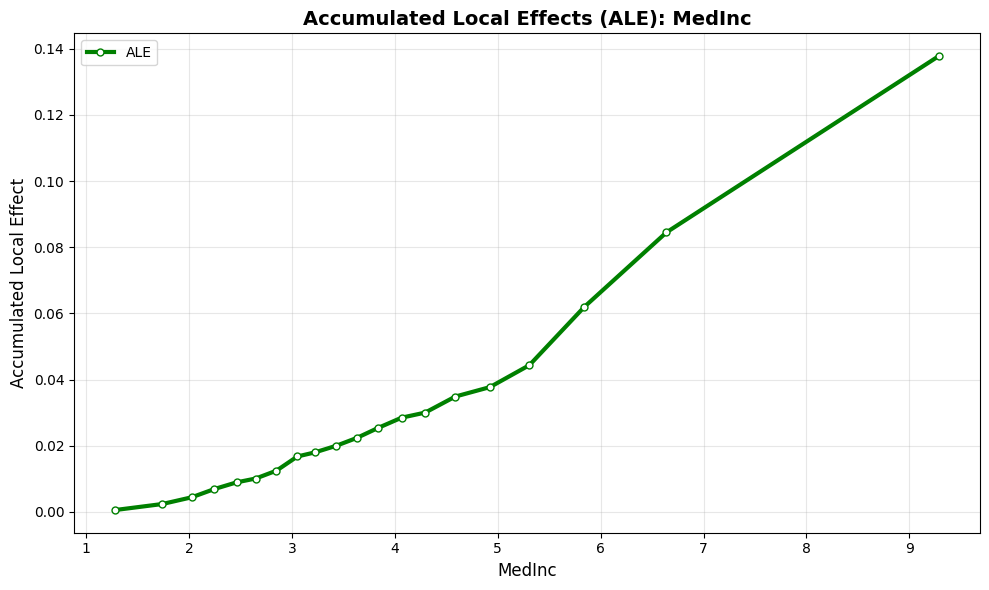

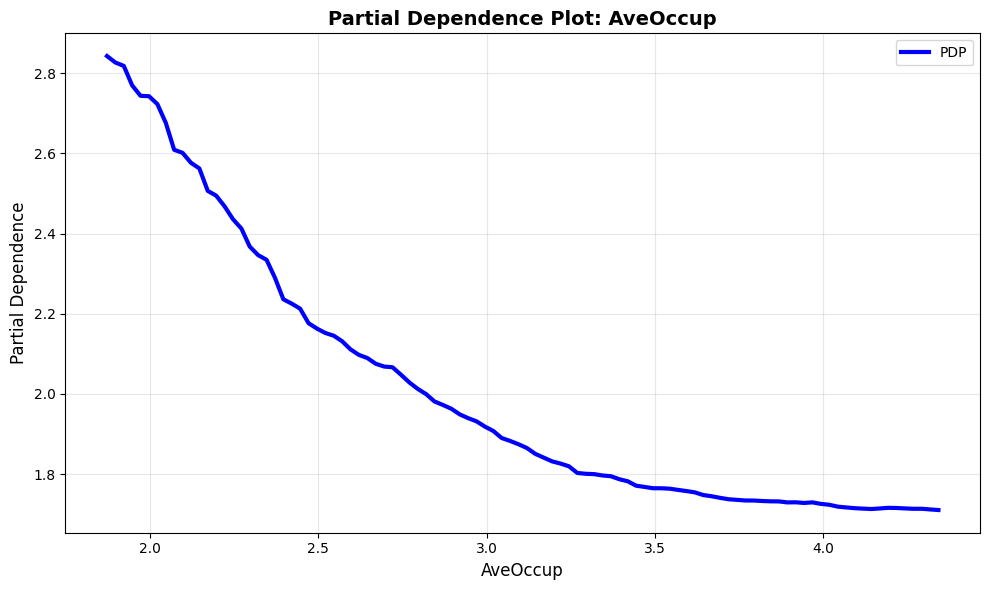

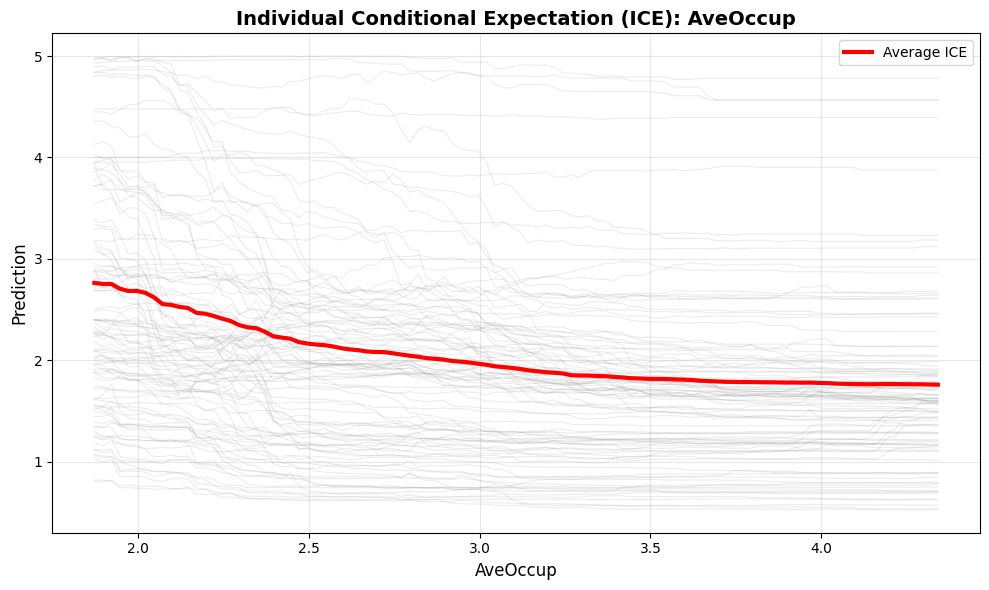

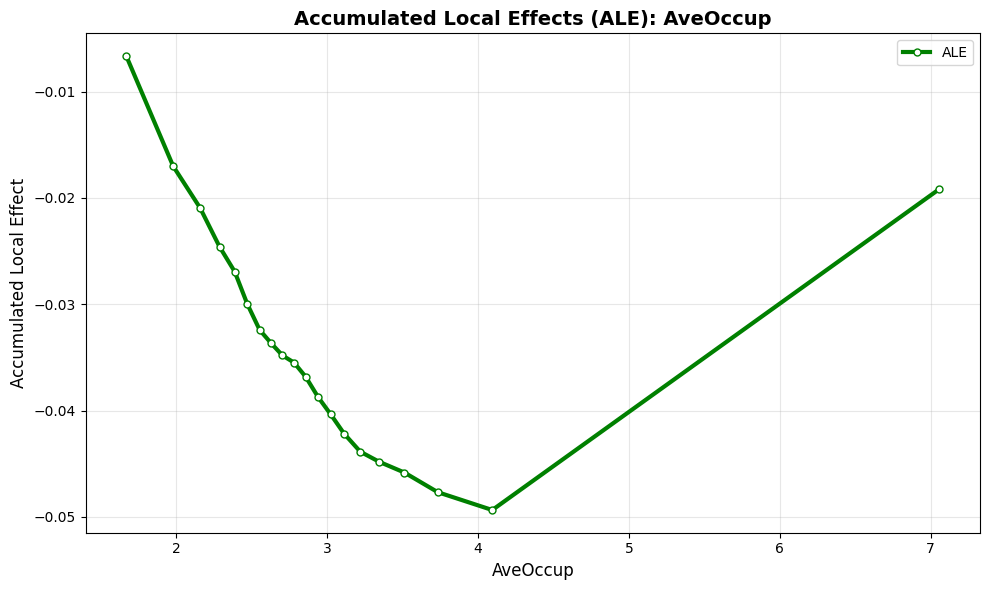

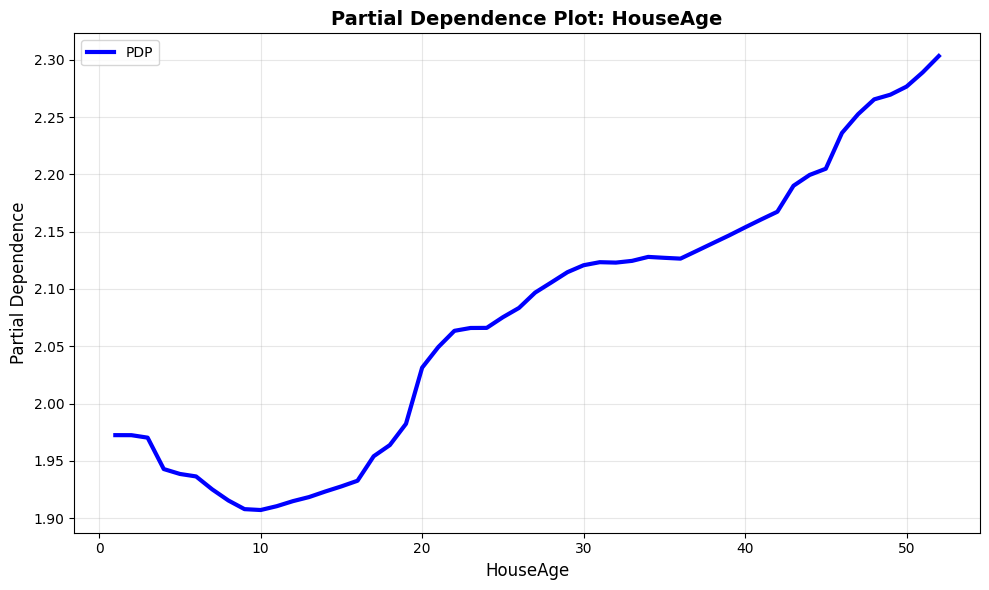

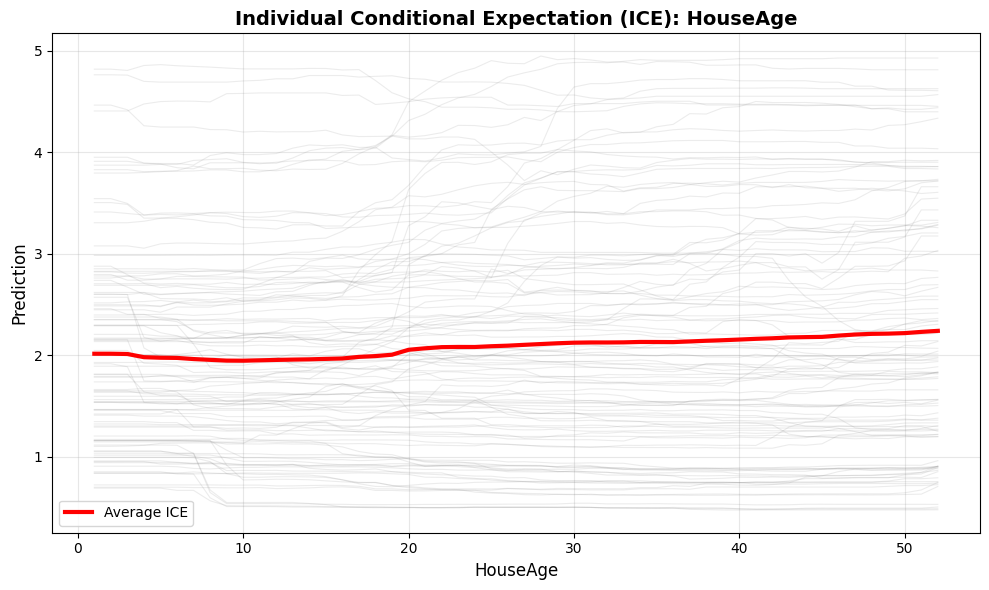

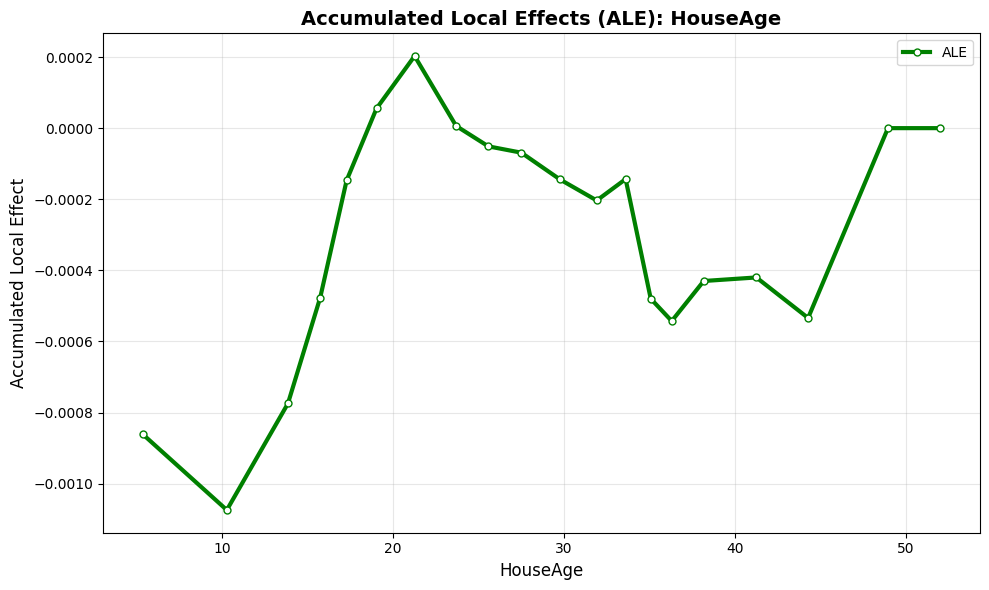

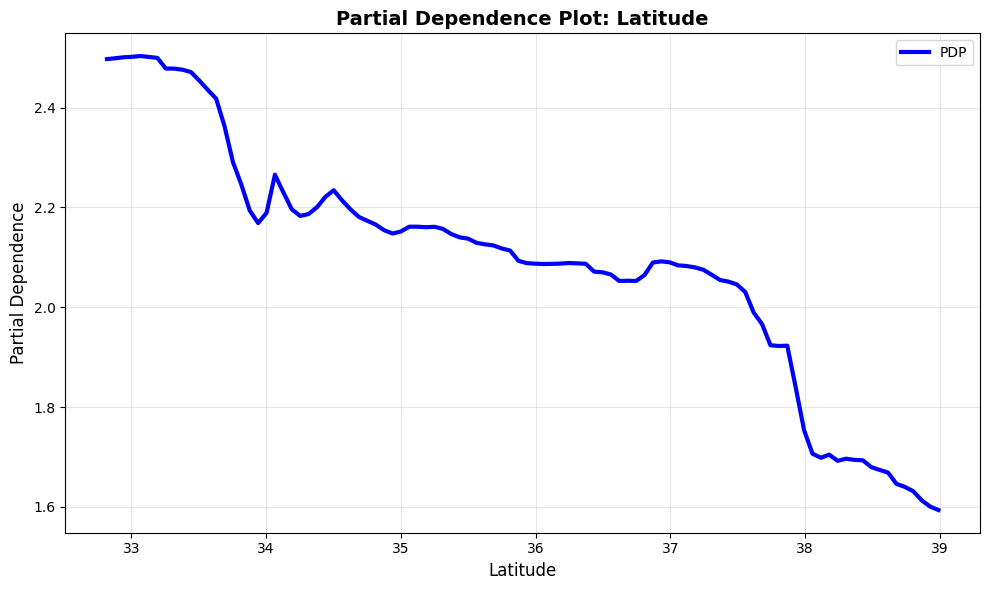

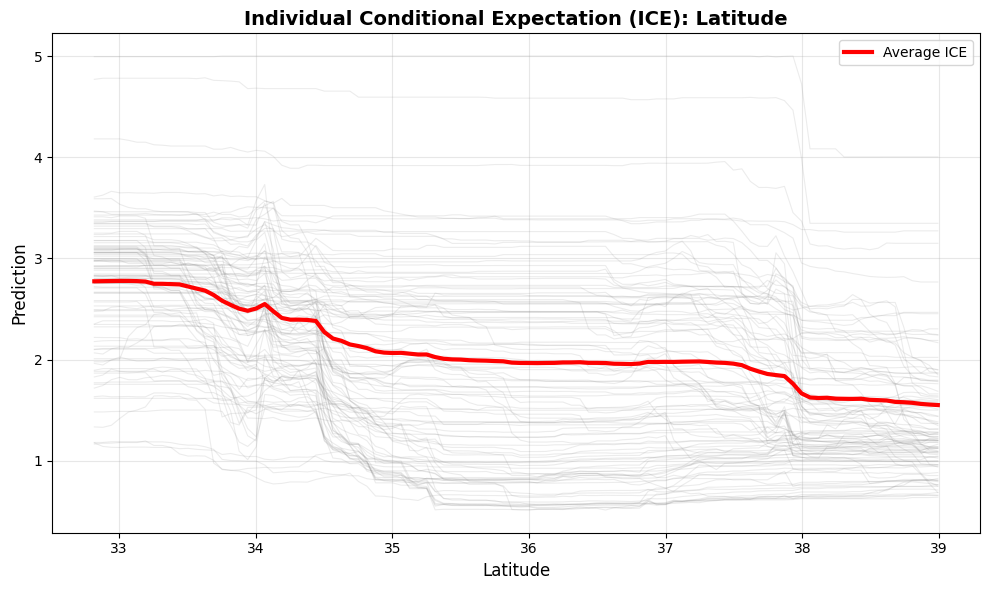

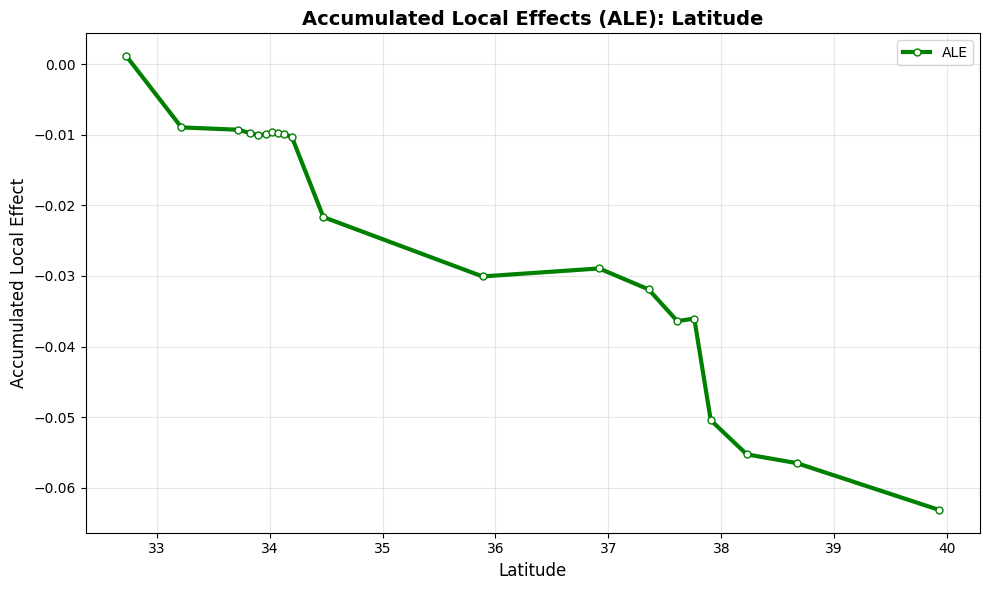

In [ ]:
# select top 4 most important/correlated features
features_to_analyze = ['MedInc', 'AveOccup', 'HouseAge', 'Latitude']
print(f"\nAnalyzing features: {features_to_analyze}")

# individual plots for each feature
for feature in features_to_analyze:
    feature_idx = list(X_train.columns).index(feature)

    # 1. PDP
    plt.figure(figsize=(10, 6))
    pdp_results = partial_dependence(rf_model, X_train, features=[feature_idx], kind='average')

    if hasattr(pdp_results, 'average'):
        pdp_values = pdp_results.average[0]
        grid_values = pdp_results.grid_values[0]
    else:
        pdp_values = pdp_results[0][0]
        grid_values = pdp_results[1][0]

    plt.plot(grid_values, pdp_values, 'b-', linewidth=3, label='PDP')
    plt.title(f'Partial Dependence Plot: {feature}', fontsize=14, fontweight='bold')
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Partial Dependence', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. ICE
    plt.figure(figsize=(10, 6))
    ice_results = partial_dependence(rf_model, X_train, features=[feature_idx], kind='individual')

    # Handle different sklearn versions
    if hasattr(ice_results, 'individual'):
        ice_values = ice_results.individual[0]
        grid_values = ice_results.grid_values[0]
    else:
        ice_values = ice_results[0]
        grid_values = ice_results[1][0]

    # plot individual lines
    n_samples = min(100, ice_values.shape[0])
    indices = np.random.choice(ice_values.shape[0], n_samples, replace=False)

    for i in indices:
        plt.plot(grid_values, ice_values[i], 'gray', alpha=0.15, linewidth=0.8)

    # average line
    avg_ice = np.mean(ice_values, axis=0)
    plt.plot(grid_values, avg_ice, 'r-', linewidth=3, label='Average ICE')
    plt.title(f'Individual Conditional Expectation (ICE): {feature}', fontsize=14, fontweight='bold')
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Prediction', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. ALE Plot
    plt.figure(figsize=(10, 6))

    # simple ALE approximation
    feature_values = X_train[feature].values
    sorted_indices = np.argsort(feature_values)
    n_bins = 20
    bin_indices = np.array_split(sorted_indices, n_bins)

    ale_values = []
    ale_points = []

    for bin_idx in bin_indices:
        if len(bin_idx) > 0:
            # get predictions for this bin
            X_bin = X_train.iloc[bin_idx].copy()

            # calculate local effect (simplified)
            bin_mean = X_bin[feature].mean()
            pred_original = rf_model.predict(X_bin)

            # perturb feature slightly
            X_bin_pert = X_bin.copy()
            perturbation = 0.1 * X_bin[feature].std()
            X_bin_pert[feature] = X_bin[feature] + perturbation
            pred_perturbed = rf_model.predict(X_bin_pert)

            ale_effect = np.mean(pred_perturbed - pred_original)
            ale_values.append(ale_effect)
            ale_points.append(bin_mean)

    # cumulative ALE
    ale_cumulative = np.cumsum(ale_values)
    plt.plot(ale_points, ale_cumulative, 'g-', linewidth=3, marker='o',
             markersize=5, label='ALE', markerfacecolor='white', markeredgecolor='green')
    plt.title(f'Accumulated Local Effects (ALE): {feature}', fontsize=14, fontweight='bold')
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Accumulated Local Effect', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

1. MedInc: Median Income

The plots show strong and consistent positive relationship. Also, since MedInc has relatively low correlations with other features, we can conclude that it's a reliable predictor.


2. AveOccup: Average Occupancy

PDP shows a strong negative relationship, where house values decrease as occupancy increases. ICE shows high variability, especially at lower occupancy levels, suggesting significant interaction effects.ALE shows U shaped curve with minimum around 4, which contrasts with PDP's monotonic decline.
So that the PDP shows continuous negative effect and ALE reveals that very high occupancy actually has less negative impact than moderate occupancy.


3. HouseAge

PDP indicates slightly U shaped relationship with minimum around age 10, then steady increase for older homes. ICE shows extremely high variability. ALE shows very small oscillations around zero. In conclusion, PDP suggests strong age effects, but ALE indicates no true causal effect of house age once correlations are controlled.


4. Latitude

PDP indicates that  house values decrease dramatically moving south, which is higher latitude lead to higher values. ICE shows a massive spread varying by 2-3 times at the same latitude. ALE has similar declining trend.


In conclusion, we notice that PDP can be misleading under correlations while ALE provide more reliable message. For example, PDP shows a negative effect of AveOccup, but ALE shows a U shape pattern.